In [1]:
import os
import rioxarray as rxr
from rasterstats import point_query, zonal_stats
from rasterstats import point_query
from rasterio.crs import CRS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import rasterstats as rs
import pandas as pd
import geopandas as gpd
# Set the font size and style
plt.rcParams.update({'font.size': 16, 'font.family': 'Helvetica'})

/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## DEM Comparison

In [3]:
UAV_DEM = rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS_UPS/ice-road/20231113_MCS_UPS-snow.tif', masked = True)
ULS_DEM = rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS_ULS/ice-road/20231113_MCS_ULS-snow.tif', masked = True)
ALS_DEM = rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS/ice-road/MCS_20231113_DEM.tif', masked = True)
QSI_DEM =rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS/ice-road/results/dem.tif', masked = True)
veg_mask = rxr.open_rasterio('/SNOWDATA/IDALS/misc_data_scripts/veg_mask.tif', masked = True)

# Get the extent of the UAV_SD raster
uav_extent = UAV_DEM.rio.bounds()
# Clip the other datasets to the extent of UAV_SD
ULS_DEM = ULS_DEM.rio.clip_box(*uav_extent)
ALS_DEM = ALS_DEM.rio.clip_box(*uav_extent)
QSI_DEM = QSI_DEM.rio.clip_box(*uav_extent)
veg_mask = veg_mask.rio.clip_box(*uav_extent)

#Reproject ALS_DEM and ULS_DEM to match UAV_DEM
ULS_DEM = ULS_DEM.rio.reproject_match(UAV_DEM, no_data = np.nan)
ALS_DEM  =  ALS_DEM.rio.reproject_match(UAV_DEM, no_data = np.nan)
QSI_DEM = QSI_DEM.rio.reproject_match(UAV_DEM, no_data = np.nan)
veg_mask = veg_mask.rio.reproject_match(UAV_DEM, no_data = np.nan)

UAV_DEM_values = UAV_DEM.values.flatten()
ULS_DEM_values = ULS_DEM.values.flatten()
ALS_DEM_values = ALS_DEM.values.flatten()
QSI_DEM_values = QSI_DEM.values.flatten()

valid_indices1 = ~np.isnan(ALS_DEM_values) & ~np.isnan(QSI_DEM_values)
ALS_DEM_values = ALS_DEM_values[valid_indices1]
QSI_DEM_values1 = QSI_DEM_values[valid_indices1]
diff1 = QSI_DEM_values1 - ALS_DEM_values


valid_indices2 = ~np.isnan(ULS_DEM_values) & ~np.isnan(QSI_DEM_values)
ULS_DEM_values = ULS_DEM_values[valid_indices2]
QSI_DEM_values2 = QSI_DEM_values[valid_indices2]
diff2 = QSI_DEM_values2 - ULS_DEM_values

valid_indices3 = ~np.isnan(UAV_DEM_values) & ~np.isnan(QSI_DEM_values)
UAV_DEM_values = UAV_DEM_values[valid_indices3]
QSI_DEM_values3 = QSI_DEM_values[valid_indices3]
diff3 = QSI_DEM_values3 - UAV_DEM_values

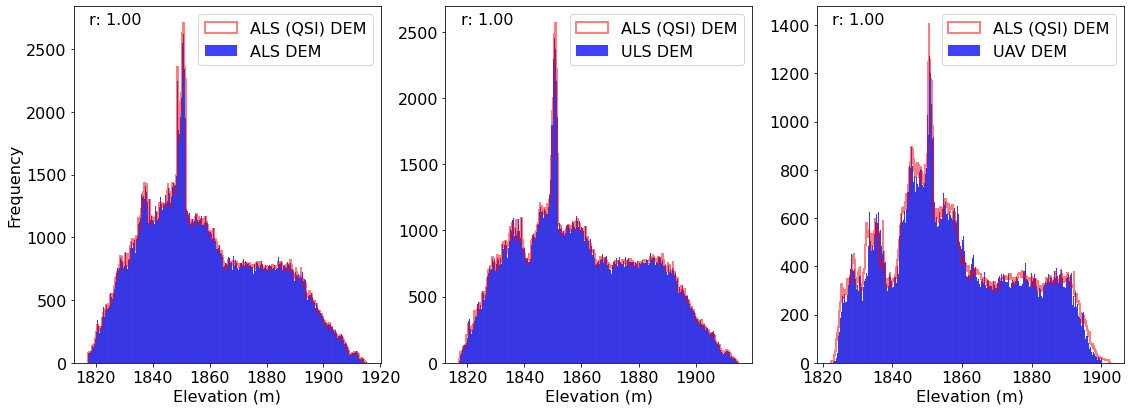

In [20]:
#Create a 1 x 3 plot of the histograms of ALS, ULS and UAV DEMs
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].hist(QSI_DEM_values1, bins=500, color='red', alpha=0.5, histtype='step', linewidth=2, label='ALS (QSI) DEM')
sns.histplot(ALS_DEM_values, bins = 500, ax = ax[0], color = 'blue',  label = 'ALS DEM')
corr1 = np.corrcoef(QSI_DEM_values1, ALS_DEM_values)[0,1] #calculate the correlation coefficient
ax[0].text(0.05, 0.95, f'r: {corr1:.2f}', transform=ax[0].transAxes) #add the correlation coefficient to the plot
ax[1].hist(QSI_DEM_values2, bins=500, color='red', alpha=0.5, histtype='step', linewidth=2, label='ALS (QSI) DEM')
sns.histplot(ULS_DEM_values, bins = 500, ax = ax[1], color = 'blue', label = 'ULS DEM')
corr2 = np.corrcoef(QSI_DEM_values2, ULS_DEM_values)[0,1] #calculate the correlation coefficient
ax[1].text(0.05, 0.95, f'r: {corr2:.2f}', transform=ax[1].transAxes) #add the correlation coefficient to the plot
ax[2].hist(QSI_DEM_values3, bins=500, color='red', alpha=0.5, histtype='step', linewidth=2, label='ALS (QSI) DEM')
sns.histplot(UAV_DEM_values, bins = 500, ax = ax[2], color = 'blue', label = 'UAV DEM')
corr3 = np.corrcoef(QSI_DEM_values3, UAV_DEM_values)[0,1] #calculate the correlation coefficient
ax[2].text(0.05, 0.95, f'r: {corr3:.2f}', transform=ax[2].transAxes) #add the correlation coefficient to the plot
ax[0].set_title('')
ax[1].set_title('')
ax[2].set_title('')
ax[0].set_xlabel('Elevation (m)')
ax[1].set_xlabel('Elevation (m)')
ax[2].set_xlabel('Elevation (m)')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()


## Validate Snow Depth for un-coregistered and co-registered

calaculate and save the snow depth for un-coregisted DEMs for Dec-12-08

In [28]:
snowon = rxr.open_rasterio('/SNOWDATA/IDALS/2023/20221208_MCS/ice-road/results/20221208_MCS_unaligned.tif', masked = True) + 3.1 #correct for antenna height
snowoff = rxr.open_rasterio('/SNOWDATA/IDALS/2023/20221208_MCS/ice-road/results/dem.tif', masked = True)
snowon_matched = snowon.rio.reproject_match(snowoff)
snowdepth = snowon_matched - snowoff
snowdepth.rio.to_raster('/SNOWDATA/IDALS/misc_data_scripts/MCS_20221208_unaligned_snowdepth.tif')

In [30]:
def lidar_val(lid_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", use_buffer = 'no'):
    # read the lidar raster data
    lidar = rxr.open_rasterio(lid_path, masked = True)
    #reproject to crs of the zone
    if lidar.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        lidar = lidar.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    # read the csv
    df = pd.read_csv(csv_path, usecols=[snowdepth_col, lat_col, lon_col])
    # convert to geodataframe
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:" + str(csv_EPSG),
    )
    # convert the gdf to crs of the zone
    gdf_utm = gdf.to_crs("EPSG:" + str(zone_utmcrs))

    #Extract the LiDAR pixels at pixel or buffered region 
    if use_buffer == "no":
        # sample the snow depth raster values at point locations
        vals = point_query(gdf_utm.geometry, lidar.squeeze().values, affine = lidar.rio.transform(), nodata = -9999)
        # add the values to a new column in the GeoDataFrame
        gdf_utm['lidar'] = vals
    else:
        # buffer the points
        gdf_utm_buffered = gdf_utm.buffer(2)
        # calculate zonal statistics of the mean within the buffer
        vals = zonal_stats(
            gdf_utm_buffered,
            lidar.squeeze().values,
            affine=lidar.rio.transform(),
            nodata=-9999,
            stats="mean",
        )
        # add the values to new columns in the GeoDataFrame
        gdf_utm['lidar'] = [stat["mean"] for stat in vals]

    #convert the unit to m
    if probe_unit == "cm":
        gdf_utm[snowdepth_col] = gdf_utm[snowdepth_col] / 100
    if lid_unit == "cm":
        gdf_utm["lidar"] = gdf_utm["lidar"]/100
    #rename the colums
    gdf_utm.rename(columns={
                       snowdepth_col: 'Probed Snow Depth (m)', 'lidar': 'LiDAR Snow Depth (m)'}, inplace=True)
    #add error column
    gdf_utm['error (cm)'] = (gdf_utm['Probed Snow Depth (m)'] - gdf_utm['LiDAR Snow Depth (m)']) * 100

    #read the road shapefile
    road = gpd.read_file('/SNOWDATA/IDALS/misc_data_scripts/3mroadBufferClip/3m_road.shp')
    # convert the gdf to crs of the zone
    road = road.to_crs("EPSG:" + str(zone_utmcrs))
    #create a 5m buffer
    road_10 = road.buffer(2)
    #sample lidar values overlapping with road_10
    values = zonal_stats(
            road_10,
            lidar.squeeze().values,
            affine=lidar.rio.transform(),
            raster_out=True, stats="mean"
        )
    masked_data = values[0]['mini_raster_array']
    lidar_road = masked_data[~masked_data.mask] 


    return gdf_utm, lidar_road


In [37]:
def plot_val(df, roadlidar, title = '', xmin = -0.4, xmax = 0.4):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 6))
    # Drop missing values
    df = df.dropna(subset=['Probed Snow Depth (m)', 'LiDAR Snow Depth (m)'])

    # Scatter plot of probed depth vs lidar depth
    sns.regplot(x='Probed Snow Depth (m)', y='LiDAR Snow Depth (m)', data=df, ax=axs[0], fit_reg=False)
    probe_min, probe_max = df['Probed Snow Depth (m)'].min(), df['Probed Snow Depth (m)'].max()
    lidar_min, lidar_max = df['LiDAR Snow Depth (m)'].min(), df['LiDAR Snow Depth (m)'].max()
    min_val = min(probe_min, lidar_min)
    max_val = max(probe_max, lidar_max)
    axs[0].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    # axs[0].set_xlabel('Probed Snow Depth (m)')
    # axs[0].set_ylabel('Predicted Snow Depth (m)')

    # Calculate correlation (r) and RMSE
    corr = np.corrcoef(df['Probed Snow Depth (m)'], df['LiDAR Snow Depth (m)'])[0, 1]
    correlation_text = f'r: {corr:.2f}'
    rmse = np.sqrt(mean_squared_error(df['Probed Snow Depth (m)'], df['LiDAR Snow Depth (m)']))
    rmse_text = f'RMSE: {rmse:.2f}'
    mbe = np.mean(df['Probed Snow Depth (m)'] - df['LiDAR Snow Depth (m)'])
    mbe_text = f'MBE: {mbe:.2f}'
    mae = np.mean(np.abs(df['Probed Snow Depth (m)'] - df['LiDAR Snow Depth (m)']))
    mae_text = f'MAE: {mae:.2f}'
    nmad = 1.4826 * np.median(np.abs(df['Probed Snow Depth (m)'] - df['LiDAR Snow Depth (m)']))
    nmad_text = f'NMAD: {nmad:.2f}'

    # Add the correlation coefficient and RMSE as text to the upper left corner
    combined_text = '\n'.join([correlation_text, rmse_text, mbe_text, mae_text, nmad_text])
    axs[0].text(0.02, 0.98, combined_text, transform=axs[0].transAxes, color='black', bbox=dict(facecolor='white', alpha=0.8), ha='left', va='top')

    # Distribution plot of error
    sns.histplot(df['error (cm)'], kde=True, ax=axs[1])
    axs[1].set_xlabel('Error (cm)')
    axs[1].set_ylabel('Frequency')

    #Distribution of lidar_on_road
    axs[2].hist(roadlidar, bins=800,  alpha=0.5, histtype='step', linewidth=2)
    axs[2].set_xlim(xmin, xmax)
    axs[2].set_xlabel('Snow Depth on road (m)')
    # Set title and adjust layout and spacing
    plt.suptitle(f'{title}')
    plt.tight_layout()

In [32]:
csv_path =  '/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/validation_data/MCS20221207_MCS20221207_secondtablet.csv'

In [35]:
pointVal_20221208, roadpointVal_20221208 = lidar_val(lid_path= '/SNOWDATA/IDALS/misc_data_scripts/MCS_20221208_unaligned_snowdepth.tif', 
                                                     csv_path = csv_path, snowdepth_col= "Depth", lat_col= "Latitude", lon_col= "Longitude")


/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/rasterstats/main.py:155: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


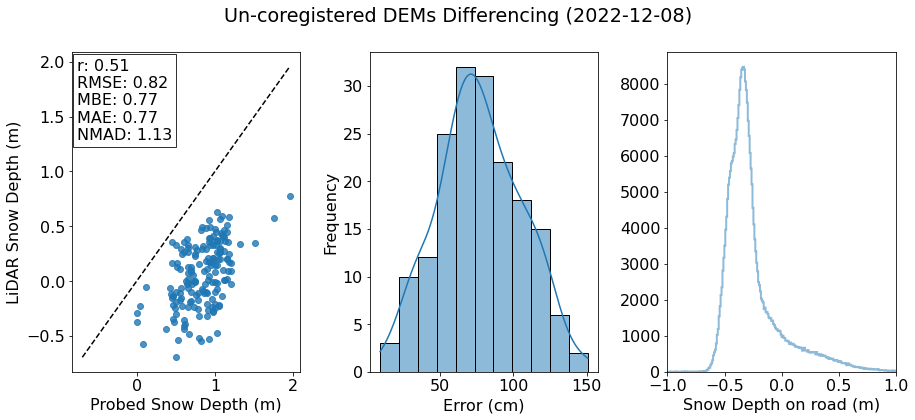

In [38]:
plot_val(pointVal_20221208, roadpointVal_20221208, title = 'Un-coregistered DEMs Differencing (2022-12-08)', xmin = -1, xmax = 1)

co-registrered

/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/rasterstats/main.py:155: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


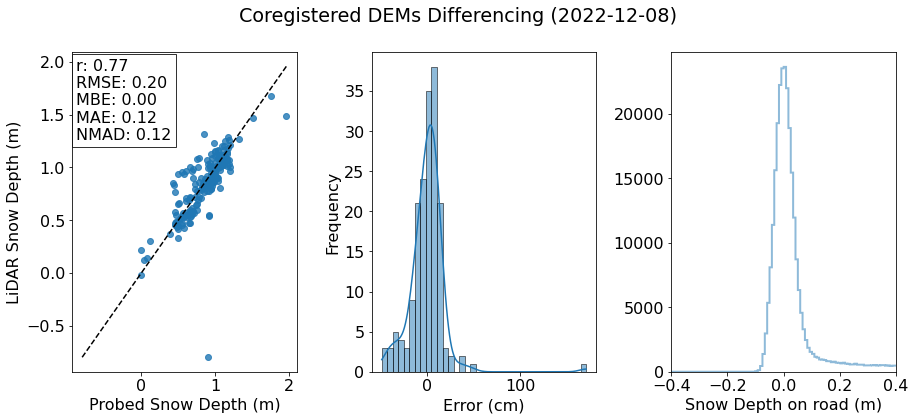

In [41]:
pointVal_20221208c, roadpointVal_20221208c = lidar_val(lid_path= '/SNOWDATA/IDALS/2023/20221208_MCS/ice-road/MCS_20221208_SNOWDEPTH.tif', 
                                                     csv_path = csv_path, snowdepth_col= "Depth", lat_col= "Latitude", lon_col= "Longitude")
plot_val(pointVal_20221208c, roadpointVal_20221208c, title = 'Coregistered DEMs Differencing (2022-12-08)')

In [42]:
pointVal_20221208c

,Probed Snow Depth (m),Latitude,Longitude,geometry,LiDAR Snow Depth (m),error (cm)
0,0.94,43.932789,-115.667511,POINT (606951.985 4865270.818),0.791664,14.833557
1,0.94,43.932789,-115.667511,POINT (606951.999 4865270.815),0.790627,14.937302
2,0.69,43.932766,-115.667603,POINT (606944.660 4865268.179),0.962218,-27.221805
3,0.78,43.932725,-115.667674,POINT (606939.064 4865263.563),1.093777,-31.377679
4,0.70,43.933140,-115.668078,POINT (606905.866 4865309.121),0.980477,-28.047656
...,...,...,...,...,...,...
172,0.62,43.934042,-115.667363,POINT (606961.667 4865410.160),0.533365,8.663484
173,0.74,43.933840,-115.667618,POINT (606941.580 4865387.453),0.639692,10.030751
174,0.93,43.933118,-115.667885,POINT (606921.429 4865306.877),0.864263,6.573721
175,0.91,43.932816,-115.667469,POINT (606955.338 4865273.898),0.778589,13.141094


In [44]:
pointVal_20221208cr

,Probed Snow Depth (m),Latitude,Longitude,geometry,LiDAR Snow Depth (m),error (cm)
48,0.9,43.938634,-115.671052,POINT (606657.363 4865915.450),-0.800518,170.051849


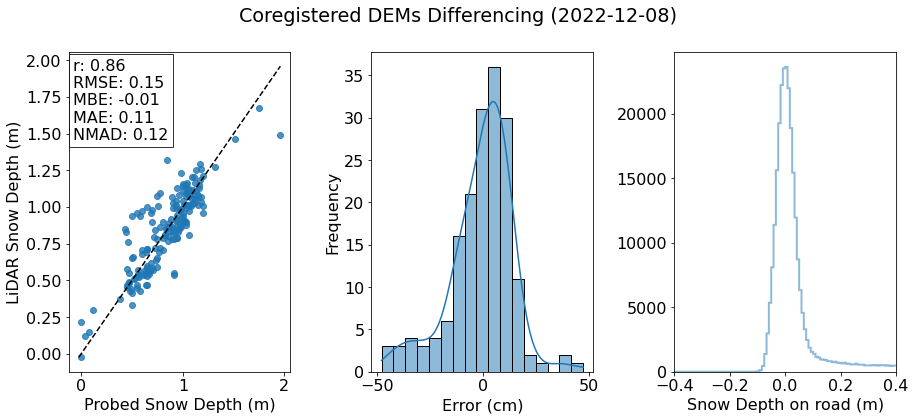

In [45]:
#There is just 1 outlier point, let's remove it
pointVal_20221208cr = pointVal_20221208c[pointVal_20221208c['LiDAR Snow Depth (m)'] > -0.5]
plot_val(pointVal_20221208cr, roadpointVal_20221208c, title = 'Coregistered DEMs Differencing (2022-12-08)')

Nov - 15 un-coregisted DEM differencing 

In [49]:
snowon = rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS/ice-road/results/AntHeightCorrected_unaligned.tif', masked = True)
snowoff = rxr.open_rasterio('/SNOWDATA/IDALS/2023/20221208_MCS/ice-road/results/dem.tif', masked = True)
snowon_matched = snowon.rio.reproject_match(snowoff)
snowdepth = snowon_matched - snowoff
snowdepth.rio.to_raster('/SNOWDATA/IDALS/misc_data_scripts/MCS_20231113_unaligned_DEMDiff.tif')

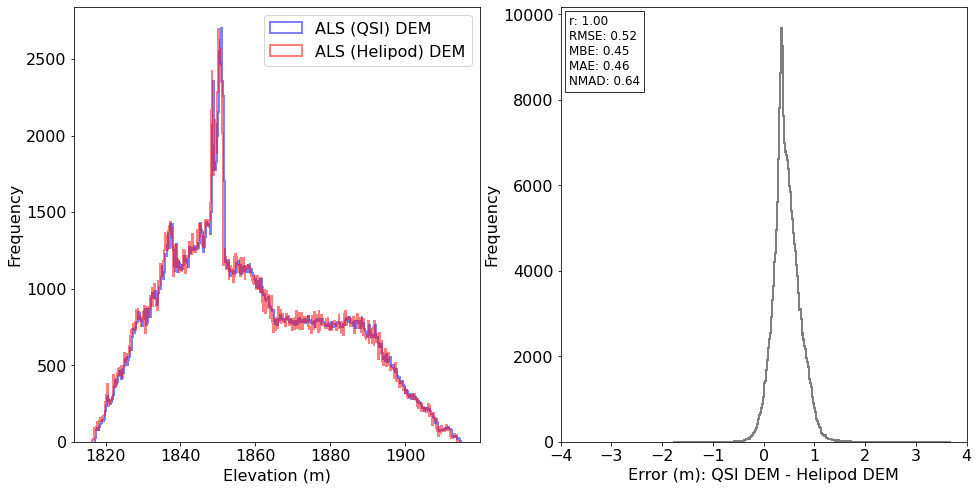

In [52]:
ALS_DEM_uc = rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS/ice-road/results/AntHeightCorrected_unaligned.tif', masked = True)
UAV_DEM = rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS_UPS/ice-road/20231113_MCS_UPS-snow.tif', masked = True)
QSI_DEM =rxr.open_rasterio('/SNOWDATA/IDALS/2024/20231113/20231113_MCS/ice-road/results/dem.tif', masked = True)

# Get the extent of the UAV_SD raster
uav_extent = UAV_DEM.rio.bounds()

# Clip the other datasets to the extent of UAV_SD
ALS_DEM_uc = ALS_DEM_uc.rio.clip_box(*uav_extent)
QSI_DEM = QSI_DEM.rio.clip_box(*uav_extent)

#Reproject ALS_DEM_uc and ULS_DEM to match UAV_DEM
ALS_DEM_uc  =  ALS_DEM_uc.rio.reproject_match(UAV_DEM, no_data = np.nan)
QSI_DEM = QSI_DEM.rio.reproject_match(UAV_DEM, no_data = np.nan)

ALS_DEM_uc_values = ALS_DEM_uc.values.flatten()
QSI_DEM_values = QSI_DEM.values.flatten()

valid_indices = ~np.isnan(ALS_DEM_uc_values) & ~np.isnan(QSI_DEM_values)
ALS_DEM_uc_values = ALS_DEM_uc_values[valid_indices]
QSI_DEM_values = QSI_DEM_values[valid_indices]
diff = QSI_DEM_values - ALS_DEM_uc_values

# Create a single figure with two subplots (histogram and heatmap)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
# Plot histogram of ALS_DEM_uc_sliced and sfm_sliced distributions
axes[0].hist(QSI_DEM_values, bins=500, color='blue', alpha=0.5, histtype='step', linewidth=2, label='ALS (QSI) DEM')
axes[0].hist(ALS_DEM_uc_values, bins=500, color='red', alpha=0.5, histtype='step', linewidth=2, label='ALS (Helipod) DEM')
axes[0].set_xlabel('Elevation (m)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

#plot the DEM difference
axes[1].hist(diff, bins=500, color='black', alpha=0.5, histtype='step', linewidth=2)
axes[1].set_xlabel('Error (m): QSI DEM - Helipod DEM')
axes[1].set_ylabel('Frequency')
# Calculate the correlation coefficient
correlation, _ = pearsonr(QSI_DEM_values, ALS_DEM_uc_values)
correlation_text = f'r: {correlation:.2f}'
# Calculate the Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(QSI_DEM_values, ALS_DEM_uc_values))
rmse_text = f'RMSE: {rmse:.2f}'
# Calculate MBE, MAE, and NMAD
mbe = np.mean(diff)
mbe_text = f'MBE: {mbe:.2f}'
mae = np.mean(np.abs(diff))
mae_text = f'MAE: {mae:.2f}'
nmad = 1.4826 * np.median(np.abs(diff))
nmad_text = f'NMAD: {nmad:.2f}'
combined_text = '\n'.join([correlation_text, rmse_text, mbe_text, mae_text, nmad_text])
axes[1].text(0.02, 0.82, combined_text, transform=axes[1].transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
axes[1].set_xlim(-4, 4)

plt.show()

## Photogrammetry Analysis

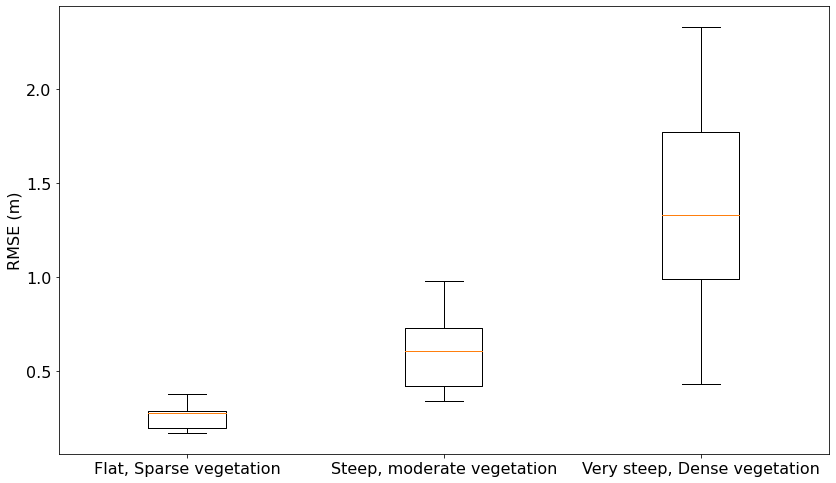

In [8]:
import matplotlib.pyplot as plt

data = {'Flat, Sparse vegetation': [0.38, 0.29, 0.28, 0.17, 0.2], 
        'Steep, moderate vegetation': [0.34, 0.42, 0.61, 0.98, 0.73],
        'Very steep, Dense vegetation': [1.33, 2.33, 0.43, 1.77, 0.99]}

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the box plot
ax.boxplot(list(data.values()), labels=list(data.keys()))

# Set the labels and title
ax.set_xlabel('')
ax.set_ylabel('RMSE (m)')
ax.set_title('')

plt.tight_layout()

# Show the plot
plt.show()

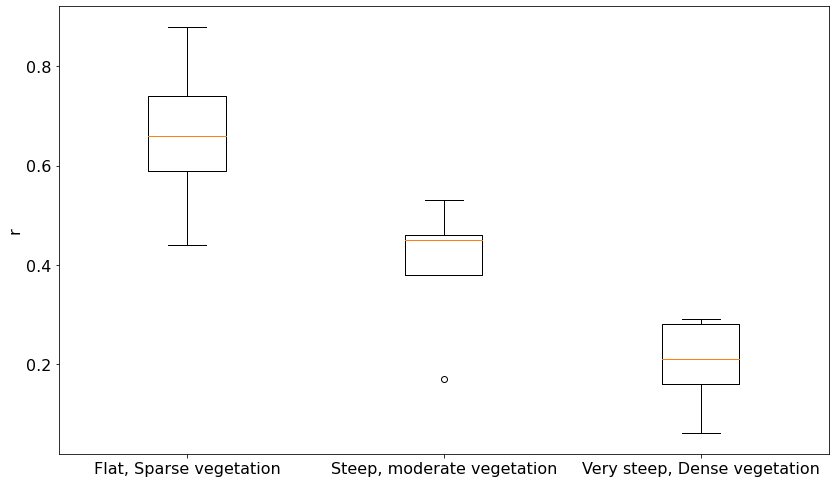

In [10]:
import matplotlib.pyplot as plt

data = {'Flat, Sparse vegetation': [0.88, 0.74, 0.59, 0.66, 0.44], 
        'Steep, moderate vegetation': [0.45, 0.53, 0.38, 0.17, 0.46],
        'Very steep, Dense vegetation': [0.16, 0.28, 0.29, 0.06, 0.21]}

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the box plot
ax.boxplot(list(data.values()), labels=list(data.keys()))

# Set the labels and title
ax.set_xlabel('')
ax.set_ylabel('r')
ax.set_title('')

plt.tight_layout()

# Show the plot
plt.show()